## Replication

This notebook looks at the strict replication and correction of the models presented within "Betting on a Buzz" Rameriez et al.

# Section 1) Data Processing

In [2]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import datetime as dt
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_stata("final.dta") #Find final.dta at https://drive.google.com/drive/folders/1GiRMkek1MnUAYzIhutt_Oie_XIq2vDO7
#this is the data used by Rameriez et al

In [3]:
df["encoded_tournament"] = df.tournament.astype('category').cat.codes # Encodes Tournament effects

In [4]:
df["match_id"] = df.index # sets match_id

# RankDiff

Very simple, calculates the difference between the winners rank and the losers rank and stores in two variables, wRankDiff and lRankDiff. Of note although they are both calculated in a similar fashion wRankDiff = -lRankdiff

In [5]:
df["wRankDiff"] = df["wrank"] - df["lrank"] 
df["lRankDiff"] = df["lrank"] - df["wrank"]

## RankDist

This equation is a little more complicated being given by

 \\( RankDist(a,b,i) = -( \dfrac{1}{rank_{ai}} - \dfrac{1}{rank_{bi}})  \\)
 
 Of note if opponant a is unranked as of the time of the match i then 
 \\( \dfrac{1}{rank_{ai}} = 0  \\)

In [7]:
def RankDist(wrank,lrank):
    if math.isnan(wrank) == True: #check if any values are NAN
        inv_wrank = 0
    else:
        inv_wrank = 1/wrank
    if math.isnan(lrank) == True:
        inv_lrank = 0
    else:
        inv_lrank = 1/lrank
    wrankdist = -(inv_wrank - inv_lrank)
    return(wrankdist) #returns the rankdist

In [8]:
df["wrankdist"] = [RankDist(wrank,lrank) for wrank,lrank in zip(df["wrank"],df["lrank"])]
df["lrankdist"] = -df["wrankdist"] #Loser Rankdist

## WikiBuzz

Calculated by \\(     WikiBuzz(a,b,i) = ln(w_{ai}/\tilde{w_{ai}}) - ln(w_{bi}/\tilde{w_{bi}}) \\)
See "Betting on a Buzz" for more information

In [9]:
def WikiBuzz(w_views,w_median_views,l_views,l_median_views):
    try:
        return(np.log(w_views/w_median_views) - np.log(l_views/l_median_views))
    except:
        return(None)
    

df["w_wikibuzz"] = [WikiBuzz(w_views,w_median_views,l_views,l_median_views) for w_views,w_median_views,l_views,l_median_views in zip(df["wiki_yesterday_w"],df["wiki_med365_w"],df["wiki_yesterday_l"],df["wiki_med365_l"])]
df["l_wikibuzz"] = [WikiBuzz(w_views,w_median_views,l_views,l_median_views) for w_views,w_median_views,l_views,l_median_views in zip(df["wiki_yesterday_l"],df["wiki_med365_l"],df["wiki_yesterday_w"],df["wiki_med365_w"])]

In [10]:
df["w_wikibuzz"].isna().sum()

9535

9535 Null Values, which is to be expected.

## Odds 

We calculate the inverse odds for average, best and bet365

In [11]:
df["inv_bet365w"] = 1/df["b365w"]
df["inv_bet365l"] = 1/df["b365l"]
df["inv_avgw"] = 1/df["avgw"]
df["inv_avgl"] = 1/df["avgl"]
df["inv_maxw"] = 1/df["maxw"]
df["inv_maxl"] = 1/df["maxl"]

This is all good for now but is quite confusing to look at, overall want a df containing each match twice in regards to winner and losers

Next step is using OLS to calculate params 

So we need a column for win/lose and the associated variables, want a df with the following columns:

MatchID, Player, Date, Year, RankDist, WikiBuzz, inv_bet365, inv_avg, inv_max, Win

Win refers to if the player won or lost the match, a win is encoded as 1 and a loss as 0 

In [12]:
win_df = df[["match_id","winner","loser","year","month","day","wRankDiff","wrankdist","w_wikibuzz","inv_bet365w","inv_avgw","inv_maxw","encoded_tournament","utc_offset","date"]].copy()
win_df["win"] = 1
win_df = win_df.set_axis(["match_id","player","opponent","year","month","day","rankdiff","rankdist","wikibuzz","inv_bet365","inv_avg","inv_max","encoded_tournament","utc_offset","date","win"], axis=1)

loss_df = df[["match_id","loser","winner","year","month","day","lRankDiff","lrankdist","l_wikibuzz","inv_bet365l","inv_avgl","inv_maxl","encoded_tournament","utc_offset","date"]].copy()
loss_df["win"] = 0
loss_df = loss_df.set_axis(["match_id","player","opponent","year","month","day","rankdiff","rankdist","wikibuzz","inv_bet365","inv_avg","inv_max","encoded_tournament","utc_offset","date","win"], axis=1)


In [13]:
final_df = pd.concat([win_df,loss_df])
final_df.sort_values(["match_id"])
#final_df.isna().sum()
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(final_df.isna().sum())
final_df = final_df.dropna(axis=0)
final_df.isna().sum()

match_id                  0
player                    0
opponent                  0
year                      0
month                     0
day                       0
rankdiff                230
rankdist                  0
wikibuzz              19466
inv_bet365              269
inv_avg                 180
inv_max                 181
encoded_tournament        0
utc_offset             1270
date                    118
win                       0
dtype: int64


match_id              0
player                0
opponent              0
year                  0
month                 0
day                   0
rankdiff              0
rankdist              0
wikibuzz              0
inv_bet365            0
inv_avg               0
inv_max               0
encoded_tournament    0
utc_offset            0
date                  0
win                   0
dtype: int64

In [14]:
final_df.sort_values(by=["year","month","day"], inplace=True)
final_df

match_id         player           opponent    year  month  day  \
12773     12773   Dellacqua C.       Svitolina E.  2015.0    7.0  2.0   
12774     12774      Giorgi C.    Arruabarrena L.  2015.0    7.0  2.0   
12775     12775  Govortsova O.          Cornet A.  2015.0    7.0  2.0   
12776     12776    Jankovic J.          Rodina E.  2015.0    7.0  2.0   
12777     12777      Kerber A.  Pavlyuchenkova A.  2015.0    7.0  2.0   
...         ...            ...                ...     ...    ...  ...   
20117     20117   Svitolina E.          Bencic B.  2019.0   11.0  2.0   
20116     20116   Pliskovax K.           Barty A.  2019.0   11.0  2.0   
20117     20117      Bencic B.       Svitolina E.  2019.0   11.0  2.0   
20118     20118       Barty A.       Svitolina E.  2019.0   11.0  3.0   
20118     20118   Svitolina E.           Barty A.  2019.0   11.0  3.0   

       rankdiff  rankdist  wikibuzz  inv_bet365   inv_avg   inv_max  \
12773      44.0  0.042430  0.000000    0.546448  0.537634  0.518135   
12774     -53.0 -0.019485  0.000000    0.900901  0.892857  0.877193   
12775      95.0  0.028840  0.000000    0.476191  0.465116  0.444444   
12776     -71.0 -0.023432  0.000000    0.819672  0.813008  0.793651   
12777     -32.0 -0.076190  0.000000    0.862069  0.877193  0.847458   
...         ...       ...       ...         ...       ...       ...   
20117       1.0  0.017857  0.919208    0.636943  0.649351  0.621118   
20116       1.0  0.500000 -0.205936    0.421941  0.408163  0.384615   
20117      -1.0 -0.017857 -0.919208    0.421941  0.401606  0.375940   
20118      -7.0 -0.875000 -0.585241    0.581395  0.558659  0.534759   
20118       7.0  0.875000  0.585241    0.476191  0.492611  0.471698   

       encoded_tournament  utc_offset     date  win  
12773                 120         1.0  20271.0    1  
12774                 120         1.0  20271.0    1  
12775                 120         1.0  20271.0    1  
12776                 120         1.0  20271.0    1  
12777                 120         1.0  20271.0    1  
...                   ...         ...      ...  ...  
20117                 118         8.0  21855.0    1  
20116                 118         8.0  21855.0    0  
20117                 118         8.0  21855.0    0  
20118                 118         8.0  21856.0    1  
20118                 118         8.0  21856.0    0  

[20062 rows x 16 columns]

In [ ]:
final_df.to_csv("final.csv")

## Section 2) The Rameriez Models

First we create train/test sets then we create the models

In [4]:
df = pd.read_csv("final.csv")

In [5]:
df["date"] = [dt.date(int(year), int(month), int(day)) for year,month,day in zip(df["year"],df["month"],df["day"])]
final_df = df

In [30]:
def plot_train(title = "Traditional ROI"):
    test_data["profit_cum"] = test_data["profit"].cumsum()
    test_data["ROI"] = (((test_data["profit"].cumsum() + test_data["kelly"].cumsum())/test_data["kelly"].cumsum())-1)*100
    test_data.plot('date', 'ROI')
    plt.ylabel('ROI (%)')
    plt.xlabel('Date')
    plt.title(title)
    plt.axhline(y=0, color='grey')

In [24]:
train_data = final_df[final_df['year'] < 2019]
test_data =final_df[final_df['year'] >= 2019]

In [ ]:
train_data.to_csv("train.csv")
test_data.to_csv("test.csv")

# Need to use OLS to calculate the following: Eq.1

\\( e(a,b,i) = \alpha + \beta_1 z_(a,b,i) + \beta_2 RankDist(a,b,i) + \beta_3 WikiBuzz(a,b,i) + \psi S(a,b,i) +\phi T(a,b,i) + \epsilon(a,b,i) \\)
    
Where Psi represents the season and Phi represents the Tournament and epsilon is noise

In [25]:
from linearmodels import PanelOLS

#function to estimate eq.1 by OLS. can get rid of rankdist or wikibuzz factors easily, returns paramters
def OLS_Params(odds,rankdist = True, wikibuzz = True,year = True,tournament = True): 
    data_params = [odds]
    if rankdist:
        data_params.append("rankdist")
    if wikibuzz:
        data_params.append("wikibuzz")
    if year:
        data_params.append("year")
    if tournament:
        data_params.append("encoded_tournament")
    X = train_data[data_params]
    y = train_data["win"] 
    X = sm.add_constant(X) 
    model = sm.OLS(y, X)
    results = model.fit()
  #  output = est.params
    const = results.params.const
    odds = results.params[1]
    print(results.params)
    if wikibuzz == False: 
         wikibuzz = 0 
    elif wikibuzz == True:
        wikibuzz = results.params.wikibuzz
    if rankdist == False: 
         rankdist = 0
    elif rankdist == True:
        rankdist = results.params.rankdist
    if year == False:
        year = 0
    elif year == True:
        year = results.params.year
    if tournament == False:
        tournament = 0
    elif tournament == True:
        tournament = results.params.encoded_tournament   
    output = [const,odds,rankdist,wikibuzz,year,tournament]
    return(output)

def OLS_rankdiff_Params(odds,rankdist = True, wikibuzz = True,year = True,tournament = True): 
    data_params = [odds]
    if rankdist:
        data_params.append("rankdiff")
    if wikibuzz:
        data_params.append("wikibuzz")
    if year:
        data_params.append("year")
    if tournament:
        data_params.append("encoded_tournament")
    X = train_data[data_params]
    y = train_data["win"] 
    X = sm.add_constant(X) 
    model = sm.OLS(y, X)
    results = model.fit()
  #  output = est.params
    const = results.params.const
    odds = results.params[1]
    print(results.params)
    if wikibuzz == False: 
         wikibuzz = 0 
    elif wikibuzz == True:
        wikibuzz = results.params.wikibuzz
    if rankdist == False: 
         rankdist = 0
    elif rankdist == True:
        rankdist = results.params.rankdiff
    if year == False:
        year = 0
    elif year == True:
        year = results.params.year
    if tournament == False:
        tournament = 0
    elif tournament == True:
        tournament = results.params.encoded_tournament   
    output = [const,odds,rankdist,wikibuzz,year,tournament]
    return(output)
    
        

In [26]:
train_data = train_data.set_index(['match_id'], append=True)

In [27]:
exog_vars = train_data[["inv_avg","rankdist"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit(cov_type='clustered', cluster_entity=True)
results

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                    win   R-squared:                        0.1580
Estimator:                   PanelOLS   R-squared (Between):              0.1580
No. Observations:               15801   R-squared (Within):               0.0000
Date:                Wed, Aug 30 2023   R-squared (Overall):              0.1580
Time:                        14:18:33   Log-likelihood                -1.011e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1481.7
Entities:                       15801   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                 F(2,15795)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             1937.9
                                        P-value                           0.0000
Time periods:                    7901   Distribution:                 F(2,15795)
Avg Obs:                       1.9999                                           
Min Obs:                       1.0000                                           
Max Obs:                       2.0000                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0290     0.0102    -2.8378     0.0045     -0.0491     -0.0090
inv_avg        1.0015     0.0181     55.305     0.0000      0.9660      1.0370
rankdist       0.0601     0.0216     2.7880     0.0053      0.0178      0.1024
==============================================================================

F-test for Poolability: 0.0633
P-value: 0.9792
Distribution: F(3,15795)

Included effects: Other Effect (year)
Model includes 1 other effect
Other Effect Observations per group (year):
Avg Obs: 3950.2, Min Obs: 1946.0, Max Obs: 4719.0, Groups: 4
PanelEffectsResults, id: 0x1f37081e490

In [28]:
x = OLS_Params("inv_avg",rankdist = False, wikibuzz = False,year = True,tournament = False) 
# odds are[inv_avg,inv_max,inv_bet365]
# everything else is a true/false
#use to calculate param est.

const     -2.974643
inv_avg    0.977641
year       0.001467
dtype: float64


## Probability

calculated through 

\\( \tilde{y}(a,b,i) = \hat{\alpha} + (1 + \hat{\beta_1})z_{a,b,i} + \hat{\beta_2} RankDist(a,b,i) + \hat{\beta_3} WikiBuzz(a,b,i) \\)


In [12]:
def probability(const_p,odds_p,rankdist_p,wikibuzz_p,year_p,tournament_p,odds,rankdist,wikibuzz): #to be used in conjuncture with a df
    return(const_p + (odds_p)*odds + rankdist_p*rankdist + wikibuzz_p*wikibuzz)



## Kelly Criterion 

   \\( x(a,b,i) = max\{ \hat{y_{a,b,i}} - \dfrac{1-\hat{y_{a,b,i}}}{o_{a,b,i} - 1},0\} \\)

In [13]:
def kelly_crit(probability,inv_odds):
               return(max((probability-((1-probability)/((1/inv_odds) - 1)),0)))


## Returns

In [14]:
def profit(kelly,inv_odds,win):
    decimal_odds = 1/inv_odds
    if win == 1: #match won
        return(kelly*decimal_odds - kelly) #profits - inital investment
    elif win == 0: #match lost
        return(-kelly) # - initial investment

## Replication of Table 1 (see Rameriez et al [1] )

Column (I)

In [28]:
exog_vars = train_data["inv_avg"]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
results.params

const     -0.016450
inv_avg    0.977647
Name: parameter, dtype: float64

Column (II)

In [29]:
exog_vars = train_data[["inv_avg","rankdiff"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
results.params

const       0.004237
inv_avg     0.938483
rankdiff   -0.000127
Name: parameter, dtype: float64

Column (III)

In [30]:
exog_vars = train_data[["inv_avg","rankdist"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
results.params

const      -0.029048
inv_avg     1.001497
rankdist    0.060101
Name: parameter, dtype: float64

Column (IV)

In [31]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
results.params

const      -0.041449
inv_avg     1.024974
rankdist    0.053794
wikibuzz    0.009127
Name: parameter, dtype: float64

Column (V)

In [32]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["encoded_tournament"])
results = model.fit()
results.params

const      -0.041422
inv_avg     1.024922
rankdist    0.053771
wikibuzz    0.009125
Name: parameter, dtype: float64

## Table 4 With Hercog Removal

Column (I)


no of bets: 224
profit: -0.27715439762881294
count    5131.000000
mean       -0.000054
std         0.006330
min        -0.064156
25%         0.000000
50%        -0.000000
75%         0.000000
max         0.139214
Name: profit, dtype: float64
ROI (%): -6.524094386219126


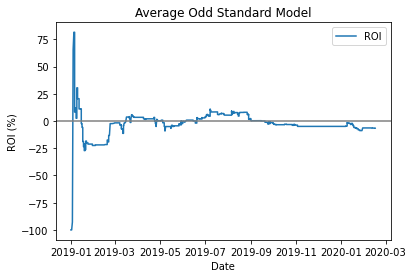

In [31]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_avg"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_avg"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((test_data["profit"].size*test_data["profit"].mean())))
#plt.plot(list(test_data["profit"].cumsum()))
plot_train("Average Odd Standard Model")
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

Column (II)


no of bets: 2313
profit: 1.8090520594558916
count    5131.000000
mean        0.000353
std         0.032245
min        -0.220113
25%         0.000000
50%         0.000000
75%         0.000000
max         0.430440
Name: profit, dtype: float64
ROI (%): 2.417860524782789


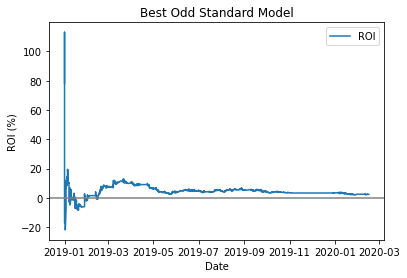

In [32]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_max"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_max"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((test_data["profit"].size*test_data["profit"].mean())))
#plt.plot(list(test_data["profit"].cumsum()))
plot_train("Best Odd Standard Model")
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

Column (III)


no of bets: 312
profit: 1.25080081957182
count    5131.000000
mean        0.000244
std         0.025713
min        -0.075763
25%         0.000000
50%         0.000000
75%         0.000000
max         1.732999
Name: profit, dtype: float64
ROI (%): 17.57368068862992


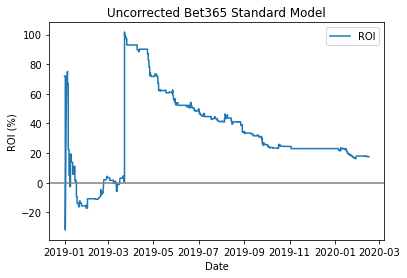

In [33]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((test_data["profit"].size*test_data["profit"].mean())))
plot_train("Uncorrected Bet365 Standard Model")
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

Column (IV)


no of bets: 274
profit: 1.458325641942358
count    5131.000000
mean        0.000284
std         0.024910
min        -0.065661
25%         0.000000
50%         0.000000
75%        -0.000000
max         1.726813
Name: profit, dtype: float64
ROI (%): 28.95449499138354


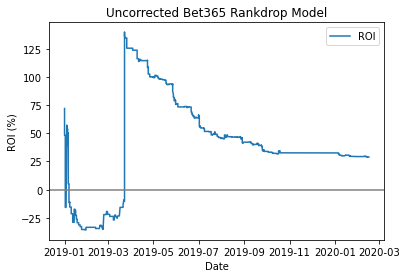

In [34]:
exog_vars = train_data[["inv_avg","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],0,x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((test_data["profit"].size*test_data["profit"].mean())))
#plt.plot(list(test_data["profit"].cumsum()))
plot_train("Uncorrected Bet365 Rankdrop Model")
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

## Hercog Removal

In [39]:
test_data.loc[test_data["match_id"]==5883]

Unnamed: 0  match_id     player   opponent    year  month   day  \
16916        5883      5883  Hercog P.     Doi M.  2019.0    3.0  23.0   
16928        5883      5883     Doi M.  Hercog P.  2019.0    3.0  23.0   

       rankdiff  rankdist  wikibuzz  ...   inv_avg   inv_max  \
16916     -19.0 -0.001824 -1.707411  ...  0.540540  0.476191   
16928      19.0  0.001824  1.707411  ...  0.495049  0.421941   

       encoded_tournament  win        date  avg_prob     kelly    profit  \
16916                 101    1  2019-03-23  0.495784  0.383736  1.726813   
16928                 101    0  2019-03-23  0.483182  0.000000 -0.000000   

       profit_cum         ROI  
16916    1.644406  139.584938  
16928    1.644406  139.584938  

[2 rows x 21 columns]

In [40]:
test_data = test_data.drop(16916, axis = 0)
test_data

Unnamed: 0  match_id          player       opponent    year  month  \
15801        1971      1971    Andreescu B.       Babos T.  2019.0    1.0   
15802        1972      1972    Anisimova A.    Cepelova J.  2019.0    1.0   
15803        1974      1974      Cirstea S.  Parmentier P.  2019.0    1.0   
15804        1976      1976      Goerges J.     Larsson J.  2019.0    1.0   
15805        1977      1977      Hsieh S.W.      Hercog P.  2019.0    1.0   
...           ...       ...             ...            ...     ...    ...   
20927        4139      4139  Alexandrova E.     Bertens K.  2020.0    2.0   
20928        4141      4141        Tig P.M.     Linette M.  2020.0    2.0   
20929        4142      4142      Sakkari M.    Rybakina E.  2020.0    2.0   
20930        4143      4143      Bertens K.    Rybakina E.  2020.0    2.0   
20931        4143      4143     Rybakina E.     Bertens K.  2020.0    2.0   

        day  rankdiff  rankdist  wikibuzz  ...   inv_avg   inv_max  \
15801   1.0      93.0  0.010370  2.667713  ...  0.591716  0.561798   
15802   1.0     -92.0 -0.005098 -0.693147  ...  0.657895  0.621118   
15803   1.0      28.0  0.005952 -0.031416  ...  0.617284  0.588235   
15804   1.0     -61.0 -0.058095 -0.530628  ...  0.847458  0.819672   
15805   1.0     -57.0 -0.023950  0.310155  ...  0.645161  0.613497   
...     ...       ...       ...       ...  ...       ...       ...   
20927  15.0      20.0  0.089286  1.323982  ...  0.483092  0.454545   
20928  15.0      63.0  0.014286 -0.517943  ...  0.396825  0.378788   
20929  15.0      -4.0 -0.007619 -1.612937  ...  0.431035  0.408163   
20930  16.0     -17.0 -0.085000 -2.935837  ...  0.641026  0.621118   
20931  16.0      17.0  0.085000  2.935837  ...  0.414938  0.386100   

       encoded_tournament  win        date  avg_prob     kelly    profit  \
15801                   3    1  2019-01-01  0.589673  0.019774  0.014237   
15802                   3    1  2019-01-01  0.623595  0.000000  0.000000   
15803                  99    1  2019-01-01  0.589190  0.000000  0.000000   
15804                   3    1  2019-01-01  0.815732  0.000000  0.000000   
15805                   3    1  2019-01-01  0.620528  0.000000  0.000000   
...                   ...  ...         ...       ...       ...       ...   
20927                  70    0  2020-02-15  0.467442  0.000000 -0.000000   
20928                 108    0  2020-02-15  0.362853  0.000000 -0.000000   
20929                  70    0  2020-02-15  0.386619  0.000000 -0.000000   
20930                  70    1  2020-02-16  0.584881  0.000000  0.000000   
20931                  70    0  2020-02-16  0.414566  0.000000 -0.000000   

       profit_cum        ROI  
15801    0.014237  72.000014  
15802    0.014237  72.000014  
15803    0.014237  72.000014  
15804    0.014237  72.000014  
15805    0.014237  72.000014  
...           ...        ...  
20927    1.458326  28.954495  
20928    1.458326  28.954495  
20929    1.458326  28.954495  
20930    1.458326  28.954495  
20931    1.458326  28.954495  

[5130 rows x 21 columns]

## Table 4

Column (I)


no of bets: 224
profit: -0.27715439762881294
count    5130.000000
mean       -0.000054
std         0.006331
min        -0.064156
25%         0.000000
50%        -0.000000
75%         0.000000
max         0.139214
Name: profit, dtype: float64
ROI (%): -6.524094386219126


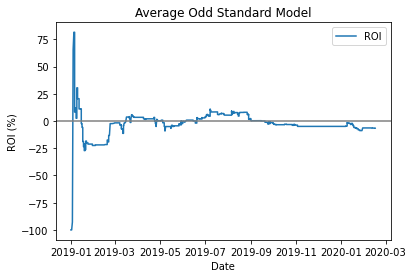

In [41]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_avg"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_avg"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((test_data["profit"].size*test_data["profit"].mean())))
#plt.plot(list(test_data["profit"].cumsum()))
plot_train("Average Odd Standard Model")
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

Column (II)


no of bets: 2312
profit: 1.7655434729264798
count    5130.000000
mean        0.000344
std         0.032243
min        -0.220113
25%         0.000000
50%         0.000000
75%        -0.000000
max         0.430440
Name: profit, dtype: float64
ROI (%): 2.3609579009739923


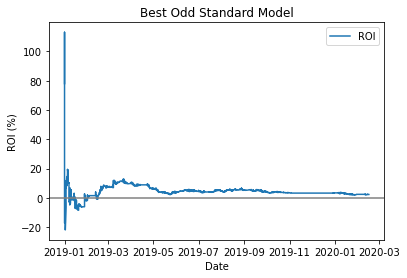

In [42]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_max"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_max"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((test_data["profit"].size*test_data["profit"].mean())))
#plt.plot(list(test_data["profit"].cumsum()))
plot_train("Best Odd Standard Model")
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

Column (III)


no of bets: 311
profit: -0.4821979156381918
count    5130.000000
mean       -0.000094
std         0.008706
min        -0.075763
25%         0.000000
50%         0.000000
75%         0.000000
max         0.171255
Name: profit, dtype: float64
ROI (%): -7.162395265800569


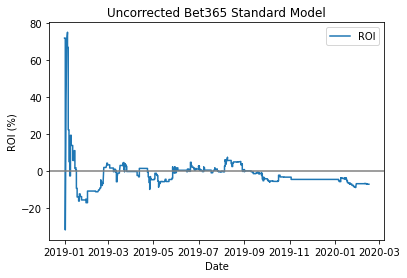

In [43]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((test_data["profit"].size*test_data["profit"].mean())))
plot_train("Uncorrected Bet365 Standard Model")
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

Column (IV)


no of bets: 273
profit: -0.2684875488889783
count    5130.000000
mean       -0.000052
std         0.006273
min        -0.065661
25%         0.000000
50%         0.000000
75%        -0.000000
max         0.145356
Name: profit, dtype: float64
ROI (%): -5.770356890986483


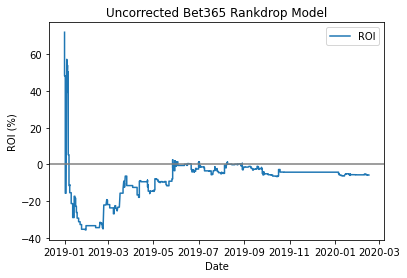

In [44]:
exog_vars = train_data[["inv_avg","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],0,x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((test_data["profit"].size*test_data["profit"].mean())))
#plt.plot(list(test_data["profit"].cumsum()))
plot_train("Uncorrected Bet365 Rankdrop Model")
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))